# Bundesanzeiger Scraping

Der folgende Code scraped die Webseite https://www.bundesanzeiger.de/. 

## Imports:

In [17]:
# for html network requests and parsing:
from bs4 import BeautifulSoup
import requests
# for displaying the captcha images:
from PIL import Image
from io import BytesIO
from IPython.display import display, HTML
from IPython.display import clear_output
# for file importing and exporting:
import csv
import pandas as pd
import json
import os
# for waiting: 
from datetime import datetime
import time
# for audio:
import simpleaudio as sa
# other:
import re # regex
from anticaptchaofficial.imagecaptcha import *
#from pathlib import Path


## Globale Variablen:

In [18]:
session_requests = requests.session()
session_id = ""
debug_prints = False

try:
    with open('credentials.json') as json_file:
        credentials = json.load(json_file)
except Exception as e:
    print("couldn't read JSON file!", repr(e))
    pass

solver = imagecaptcha()
solver.set_verbose(1)
solver.set_key(credentials['secret_key'])

# Basisfunktionen:

## get_search_results

Diese Funktion stellt eine Anfrage an die Suchmaske von https://www.bundesanzeiger.de/ und gibt die Ergebnistabelle als Dataframe zurück.

Diese Funktion wird direkt aufgerufen.

In [19]:
def get_search_results(search_string):
    global session_id
    global debug_prints
    # genericsearch_param.part_id: 22 is for just Jahresabschlüsse
    payload = {'page.navid': 'to_detailsearch', 'global_data.designmode': 'eb', '(page.navid=to_quicksearchlist)': 'Suchen', 'genericsearch_param.part_id': '22', 'genericsearch_param.hitsperpage': '20'}
    payload.update({'genericsearch_param.fulltext': search_string})
    if session_id != "":
        payload.update({'session.sessionid': session_id})

    url = 'https://www.bundesanzeiger.de/ebanzwww/wexsservlet'
    # time.sleep(0.33) # wait some seconds before the next request, to not overwhelm the server
    try:
        result = session_requests.get(url, params = payload)
    except Exception as e:
        print('Error in getting search result!', repr(e))
        result = None
    if debug_prints:
        print("get_searchresults url:", result.url)
        print("get_searchresults returned:", result.status_code, result.headers['content-type'])

    if result is not None:
        # Get html content
        soup = BeautifulSoup(result.text, "lxml")
        # Parse for session id, update variable
        session_id = soup.find('a', href=True)['href']
        session_id = session_id[session_id.find("session.sessionid=")+len("session.sessionid="):session_id.find("&", session_id.find("session.sessionid="))]
        if debug_prints:
            print("session_id:", session_id)

        # Parse html content
        result_table = soup.find("table", attrs={"class": "result", "summary": "Trefferliste"})
        rows = result_table.find_all("tr")
        table_contents = []
        for tr in rows:
            # header row
            if rows.index(tr) == 0 :
                row_cells = [ th.getText(separator=" ").strip() for th in tr.find_all('th') if th.getText().strip() != '' ] + ["session.sessionid=", "fts_search_list.selected", "fts_search_list.destHistoryId", "timestamp"]
            # data rows
            else:
                # get 'th' element text
                row_cells = ([ tr.find('th').getText(separator=" ") ] if tr.find('th') else [] ) + \
                [ td.getText(separator=" ").strip() for td in tr.find_all('td') if td.getText().strip() != '' ] + \
                [ a['href'][a['href'].find("session.sessionid=")+len("session.sessionid="):a['href'].find("&", a['href'].find("session.sessionid="))] for a in tr.find_all('a', href=True)] + \
                [ a['href'][a['href'].find("fts_search_list.selected=")+len("fts_search_list.selected="):a['href'].find("&", a['href'].find("fts_search_list.selected="))] for a in tr.find_all('a', href=True)] + \
                [ a['href'][a['href'].find("fts_search_list.destHistoryId=")+len("fts_search_list.destHistoryId="):] for a in tr.find_all('a', href=True)] + \
                [ time.ctime() ]
            if len(row_cells) > 1 :
                table_contents += [ row_cells ]

        # Convert to dataframe and set first row as headers
        df = pd.DataFrame.from_dict(table_contents)
        df.columns = df.iloc[0]
        df = df[1:]
        return df
    else:
        print('get_search_results had an erorr!')
        df = pd.DataFrame()
        return df

## get_captcha

Bevor eine Dokumentenanfrage mit dem gewünschen Ergebnis beantwortet wird, muss der User ein Captcha lösen. Hier wird die Lösung dem Nutzer gezeigt und seine Eingabe verlangt.

Es gibt hier zwei Funktionen zur Auswahl: get_image_captcha sowie get_image_and_audio_captcha

In [20]:
# this function gets just the image captcha
def get_image_captcha(session_id, save_captcha_files):
    global debug_prints
    payload = {'state.action':'captcha','captcha_data.mode':'image'}
    payload.update({'session.sessionid': session_id})
    url = 'https://www.bundesanzeiger.de/ebanzwww/contentloader'
    try:
        result = session_requests.get(url, params = payload)
    except Exception as e:
        print('Error in getting image captcha!', repr(e))
        result = None
    if debug_prints:
        print("get_captcha url", result.url)
        print("get_captcha returned:", result.status_code, result.headers['content-type'])

    if result is not None:
        if result.headers['content-type'] == "image/jpeg":

            ## here the image could be saved as a file:
            if save_captcha_files:
                try:
                    with open('scraped_data/captchas/captcha.jpg', 'w+b') as file:
                        file.write(result.content)
                except Exception as e:
                    print("saving captcha.jpg failed!", repr(e))
                    pass

            img = Image.open(BytesIO(result.content))
            display(img)
            print('Please solve this captcha. To cancel, type "exit"')
            captcha_solution = ""
            time.sleep(0.1)
            # captcha_solution = input()

            captcha_solution = solver.solve_and_return_solution('scraped_data/captchas/captcha.jpg')
            if captcha_solution != 0:
                print("captcha text "+captcha_solution)
                return captcha_solution
            else:
                print("task finished with error "+solver.error_code)
                return ''
        else:
            print("no image returned")
            return ""
    else:
        print('get_image_captcha returned an error!')
        return ''

In [21]:
# first get a image and then audio captcha, else service doesn't correctly process request
def get_image_and_audio_captcha(session_id, save_captcha_files):
    global debug_prints
    payload = {'state.action':'captcha','captcha_data.mode':'mixed-image'}
    payload.update({'session.sessionid': session_id})
    url = 'https://www.bundesanzeiger.de/ebanzwww/contentloader'
    # here the captcha image is requested
    try:
        result = session_requests.get(url, params = payload)
    except Exception as e:
        print('Error in getting image captcha!', repr(e))
        result = None
    if debug_prints:
        print("get_captcha url", result.url)
        print("get_captcha returned:", result.status_code, result.headers['content-type'])

    if result is not None:
        if result.headers['content-type'] == "image/jpeg":

            # here the image could be saved as a file:
            if save_captcha_files:
                try:
                    with open('scraped_data/captchas/captcha.jpg', 'w+b') as file:
                        file.write(result.content)
                except Exception as e:
                    print("saving captcha.jpg failed!", repr(e))
                    pass

            img = Image.open(BytesIO(result.content))
            display(img)
            # now, request captcha audio
            payload = {'state.action':'captcha','captcha_data.mode':'mixed-audio'}
            payload.update({'session.sessionid': session_id})
            url = 'https://www.bundesanzeiger.de/ebanzwww/contentloader'
            try:
                result = session_requests.get(url, params = payload)
            except Exception as e:
                print('Error in getting audio captcha!', repr(e))
            if debug_prints:
                print("get_captcha url", result.url)
                print("get_captcha returned:", result.status_code, result.headers['content-type'])

            if result.headers['content-type'] == "audio/wav":

                # here the audio could be saved as a file:
                if save_captcha_files:
                    try:
                        with open('scraped_data/captchas/captcha.wav', 'w+b') as file:
                            file.write(result.content)
                    except Exception as e:
                        print("saving captcha.wav failed!", repr(e))
                        pass

                print('Please solve this captcha. To cancel, type "exit". To replay, type "replay".')
                captcha_solution = "replay"
                # play the audio captcha to the user
                while captcha_solution == "replay":
                    wave_obj = sa.WaveObject.from_wave_file(BytesIO(result.content))
                    play_obj = wave_obj.play()
                    captcha_solution = solver.solve_and_return_solution('scraped_data/captchas/captcha.jpg')
                    if captcha_solution != 0:
                        print("captcha text "+captcha_solution)
                    else:
                        print("task finished with error "+solver.error_code)
                        captcha_solution = ''
                    play_obj.wait_done()
                    if debug_prints:
                        print("your solution:", captcha_solution)
                return captcha_solution
            else:
                print("no audio returned")
                return ""
        else:
            print("no image returned")
            return ""
    else:
        print('get_image_and_audio_captcha returned an error!')
        return ''



## get_document

Mit dieser Funktion werden Dokumente abgerufen und deren HTML-Inhalt zurückgegeben. Dabei wird auch das vorgeschaltete Captcha beachtet und über get_captcha dem Nutzer gezeigt und abgefragt.

Diese Funktion wird direkt aufgerufen.

In [22]:
def get_document(search_list_selected, search_list_destHistoryId, save_captcha_files, get_audio_captcha):
    global session_id
    global debug_prints
    keepcharacters = (' ','.','_', '-')
    retry_counter = 0
    payload = {'page.navid':'detailsearchlisttodetailsearchdetail'}
    payload.update({'session.sessionid': session_id})
    payload.update({'fts_search_list.selected': search_list_selected})
    payload.update({'fts_search_list.destHistoryId': search_list_destHistoryId})
    payload.update({'captcha_data.mode': 'mixed-image'})
    url = 'https://www.bundesanzeiger.de/ebanzwww/wexsservlet'
    # time.sleep(2) # wait 2 seconds before the next request, to not overwhelm the server
    try:
        result = session_requests.get(url, params = payload)
    except Exception as e:
        print('Error in getting initial documant page!', repr(e))
        result = None
    if debug_prints:
        print("get_details url:", result.url)
        print("get_details returned:", result.status_code, result.headers['content-type'])

    if result is not None:
        # Parse the html content
        soup = BeautifulSoup(result.text, "lxml")
        # Parse for session id, update variable
        session_id = soup.find('a', href=True)['href']
        session_id = session_id[session_id.find("session.sessionid=")+len("session.sessionid="):session_id.find("&", session_id.find("session.sessionid="))]
        # check if page has a captcha
        if soup.find("div", attrs={"class": "image_captcha"}) is not None :
            #print("Captcha found")
            captcha_found = True
            captcha_solution = ""
            if get_audio_captcha:
                captcha_solution = get_image_and_audio_captcha(session_id, save_captcha_files)
            else:
                captcha_solution = get_image_captcha(session_id, save_captcha_files)
            #if captcha_solution == "" or captcha_solution == "exit":
            if captcha_solution.lower() == "exit":
                # if captcha was not solved
                return "exit"
            else:
                # if captcha was solved, solution will be posted to server and response will be checked for new captcha
                while captcha_found == True:
                    # POST captcha solution
                    post_payload = {"genericsearch_param.part_id":"","(page.navid=detailsearchdetailtodetailsearchdetailsolvecaptcha)":"OK"}
                    post_payload.update({'session.sessionid': session_id})
                    post_payload.update({'captcha_data.solution': captcha_solution})
                    post_url = 'https://www.bundesanzeiger.de/ebanzwww/wexsservlet'
                    try:
                        result = session_requests.post(post_url, data = post_payload)
                        retry_counter = 0
                    except Exception as e:
                        print('Error in posting captcha!', repr(e))
                        print('retrying now...')
                        retry_counter = retry_counter + 1
                        if retry_counter < 4:
                            continue
                    if debug_prints:
                        print("post_captcha url: ", result.url)
                        print("post_captcha returned: ", result.status_code, result.headers['content-type'])
                    # Check for captcha again
                    soup = BeautifulSoup(result.text, "lxml")
                    # Parse for session id, update variable
                    session_id = soup.find('a', href=True)['href']
                    session_id = session_id[session_id.find("session.sessionid=")+len("session.sessionid="):session_id.find("&", session_id.find("session.sessionid="))]
                    # check if page has a captcha again
                    if soup.find("div", attrs={"class": "image_captcha"}) is not None :
                        print("WRONG captcha, new captcha found -- PLEASE TRY AGAIN")
                        captcha_found = True
                        captcha_solution = ""
                        if get_audio_captcha:
                            captcha_solution = get_image_and_audio_captcha(session_id, save_captcha_files)
                        else:
                            captcha_solution = get_image_captcha(session_id, save_captcha_files)
                        #if captcha_solution == "" or captcha_solution == "exit":
                        if captcha_solution == "exit":
                            return "exit"
                        # ... if a solution was provided by the user, the loop then starts again
                    else:
                        captcha_found = False
                        print("Captcha successfully solved!")
                        if save_captcha_files:
                            try:
                                os.rename("scraped_data/captchas/captcha.jpg", "scraped_data/captchas/captcha_"+captcha_solution+".jpg")
                                os.rename("scraped_data/captchas/captcha.wav", "scraped_data/captchas/captcha_"+captcha_solution+".wav")
                            except Exception as e:
                                pass
                        return soup
                    # ... loop starts again
                return soup
        else:
            return soup
    else:
        print('get_document returned an error!')
        return ''

# Weitere Funktionen:

## scrape single company

In [23]:
# this function gets the result of the single company
def get_single_company(company, place, from_year, print_title, save_captcha_files, get_audio_captcha, retry_counter=0) -> bool:
    global session_id
    global debug_prints

    # for company name sanitizing
    keepcharacters = (' ','.','_', '-')
    regex1 = re.compile(r'bis zum \d{2}\.\d{2}\.(\d{4})')
    csv_filename = 'scraped_data/'+"".join(c for c in company if c.isalnum() or c in keepcharacters).rstrip()+'.csv'
    abort_execution = False
    rerun_function = False
    document_counter = 0
    current_counter = 0

    clear_output(wait=True)
    print(print_title)
    print("COMPANY:", company, '/', place,'/ earliest review', from_year)

    # get search results
    try:
        df = get_search_results(company)
        if isinstance(df, pd.DataFrame):
            df.to_csv(csv_filename, index=False, encoding='utf-8', sep=';', quoting=csv.QUOTE_ALL)
    except Exception as e:
        print('Dataframe could not be saved as CSV!', repr(e))
        df = None
        pass


    # count how many douments of search results are to be fetched
    if df is not None and isinstance(df, pd.DataFrame):
        for index, row in df.iterrows():
            if row[0] != "Suche - kein Suchergebnis" and isinstance(row[2], str):
                t = regex1.search(row[2])
                if t is not None:
                    if int(t.group()[-4:]) >= from_year:
                        document_counter = document_counter + 1

    # get documents of search results
    if document_counter > 1:
        if df is not None and isinstance(df, pd.DataFrame):
            for index, row in df.iterrows():
                if row[0] != "Suche - kein Suchergebnis" and isinstance(row[2], str):
                    # filename like '%searchstring%_%documentdate%.html'
                    html_filename = "".join(c for c in company if c.isalnum() or c in keepcharacters).rstrip()+"_"+row[3]+".html"
                    # if the file for the current document does NOT exist, request it
                    # else, the document will not be requested -- this avoids double work
                    if not os.path.exists(os.path.join('scraped_data', html_filename)):
                        t = regex1.search(row[2])
                        if t is not None:
                            if int(t.group()[-4:]) >= from_year:
                                current_counter = current_counter+1
                                clear_output(wait=True)
                                print(print_title)
                                print("COMPANY:", company, '/', place,'/ earliest review', from_year)
                                print('NEXT DOCUMENT (', current_counter, '/', document_counter, '):')
                                print('>', row[0])
                                print('> Dokument vom', row[3])
                                print('>', row[2], '\n')
                                if row[5] == session_id:
                                    # here the document is requested:
                                    html_result = get_document(row[6], row[7], save_captcha_files, get_audio_captcha)
                                    if html_result == "exit":
                                        abort_execution = True
                                        print("Execution was aborted!")
                                        break
                                    elif html_result != "":
                                        # check for invalidity here
                                        invalid_id = html_result.findAll(class_='invalid')
                                        if invalid_id:
                                            print('The returned document was invalid, there was some error on the server-side. Will try again now...')
                                            time.sleep(0.5)
                                            rerun_function = True
                                            break
                                        else: # if document is valid:
                                            try:
                                                # filename like '%searchstring%_%documentdate%.html'
                                                with open(os.path.join('scraped_data', html_filename), "w", encoding='utf-8') as file:
                                                    file.write(str(html_result))
                                            except Exception as e:
                                                print("could not save HTML file", repr(e))

                                else:
                                    print("Session ID of searchresult does not match, entry will be skipped.")
                    else:
                        current_counter = current_counter+1
                        clear_output(wait=True)
                        print(print_title)
                        print("COMPANY:", company, '/', place,'/ earliest review', from_year)
                        print('NEXT DOCUMENT (', current_counter, '/', document_counter, '):')
                        print('>', row[0])
                        print('> Dokument vom', row[3])
                        print('>', row[2], '\n')
                        print("HTML file already exists for this document!!")
                        # time.sleep(0.5)
                else:
                    print("No search result!")
                    # time.sleep(0.5)
                    break
        else:
            print('No search result!')
            # time.sleep(0.5)
    else:
        print('Too few documents in scope!')

    if abort_execution:
        return False

    if rerun_function and retry_counter < 4: # will do once and then re-try three times
        final_result = get_single_company(company=company, place=place, from_year=from_year,
                                          print_title=print_title, save_captcha_files=save_captcha_files,
                                          get_audio_captcha=get_audio_captcha, retry_counter=(retry_counter+1))
        return final_result

    print("Done for this company!")
    # time.sleep(0.5)

    return True # means everything is OK


# Ausführung:


=== Getting documents for company 2812/5000 of 13909 ===
COMPANY: STEM Healthcare Germany GmbH / Kaufbeuren / earliest review 2018
NEXT DOCUMENT ( 1 / 2 ):
> STEM Healthcare Germany GmbH München
> Dokument vom 12.02.2020
> » Jahresabschluss zum Geschäftsjahr vom 01.10.2018 bis zum 30.09.2019 

Please solve this captcha. To cancel, type "exit"
making request to createTask
created task with id 781832936
making request to getTaskResult
task is still processing
making request to getTaskResult
task is still processing
making request to getTaskResult


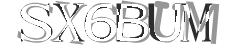

In [ ]:
filepath_merged_companies='company_timestamps.json'

abort_execution = False

# get company data from file
try:
    with open(filepath_merged_companies) as json_file:
        company_names = json.load(json_file)
        merged_companies_len = len(company_names)
except Exception as e:
    print("couldn't read JSON file!", repr(e))
    pass

# get counter from file
try:
    with open('current_index.json', 'r') as file:
        save_list = json.load(file)
    counter_curr = save_list[0]
    counter_to = save_list[1]
except Exception as e:
    counter_curr = 0
    counter_to = merged_companies_len




# loop through all companies
for item in company_names:
    if counter_curr <= company_names.index(item) < counter_to:

        # get all douments for single company, save return value in variable
        abort_execution = not get_single_company(from_year=int(item[1]), company=item[0].strip(), place=item[4].strip(),
                                                 print_title="=== Getting documents for company "+str(company_names.index(item)+1)+"/"+str(counter_to)+' of '+str(merged_companies_len)+" ===",
                                                 save_captcha_files=True, get_audio_captcha=False)

        if not abort_execution:
            counter_curr = counter_curr + 1
            # save current index
            try:
                with open('current_index.json', 'w') as f:
                    save_list = [counter_curr, counter_to]
                    json.dump(save_list, f)
            except Exception as e:
                print("index saving failed", repr(e))
        else:
            break



if abort_execution:
    print('Execution was stopped.')

